# Proyecto 03 - Sistemas de Recomendación

## Dataset: STEAM

**Recuerda descargar el dataset de [aquí](https://github.com/kang205/SASRec). Son dos archivos, uno de calificaciones y otro de información sobre los juegos.**

En este notebook te dejamos unas celdas para que puedas comenzar a trabajar con este dataset. Sin embargo, **deberás** modificarlas para hacer un mejor manejo de datos. Algunas cosas a las que deberás prestar atención (tal vez no a todas):
1. Tipos de datos: elige tipos de datos apropiados para cada columna.
2. Descartar columnas poco informativas.
3. Guardar en memoria datasets preprocesados para no tener que repetir código que tarde en correr.

### Exploración de datos

Dedícale un buen tiempo a hacer un Análisis Exploratorio de Datos. Elige preguntas que creas que puedas responder con este dataset. Por ejemplo, ¿cuáles son los juegos más populares?¿Y los menos populares?

### Filtro Colaborativo

Deberás implementar un sistema de recomendación colaborativo para este dataset. Ten en cuenta:

1. Haz todas las transformaciones de datos que consideres necesarias. Justifica.
1. Evalúa de forma apropiada sus resultados. Justifica la métrica elegida.
1. Elige un modelo benchmark y compara tus resultados con este modelo.
1. Optimiza los hiperparámetros de tu modelo.

Puedes implementar un filtro colaborativo a partir de la similitud coseno o índice de Jaccard. ¿Puedes utilizar los métodos de la librería Surprise? Si no es así, busca implementaciones (por ejemplo, nuevas librerías) que sean apropiadas.

Para comenzar a trabajar, puedes asumir que cada entrada es un enlace entre una persona usuaria y un item, **independientemente** de si la crítica es buena o mala. 

### Para pensar, investigar y, opcionalmente, implementar
1. ¿Cómo harías para ponerle un valor a la calificación?
1. ¿Cómo harías para agregar contenido? Por ejemplo, cuentas con el género, precio, fecha de lanzamiento y más información de los juegos.
1. ¿Hay algo que te gustaría investigar o probar?

### **¡Tómate tiempo para investigar y leer mucho!**

In [300]:
import gzip
import pandas as pd
import numpy as np
import itertools
import plotly.express as px
import plotly.graph_objects as go
import missingno as msno
from time import strptime
import datetime
import re
import nltk
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud, ImageColorGenerator
import matplotlib.pyplot as plt
from PIL import Image
from scipy.ndimage import gaussian_gradient_magnitude

In [2]:
def parse(path):
    g = gzip.open(path, 'r')
    for l in g:
        yield eval(l)

#### Reviews

Obteniendo todos los datos:

In [3]:
#contador = 0
data_reviews = []
# Vamos a guardar una de cada 10 reviews para no llenar la memoria RAM. Si pones n = 3, 
# abrira uno de cada tres, y asi.
#n = 2
for l in parse('steam_reviews.json.gz'):
    #if contador%n == 0:
    data_reviews.append(l)
    #else:
    #    pass
    #contador += 1

Recibimos las columnas necesarias para el preprocesamiento y análisis, además agiliza la conversión a DataFrame.

In [4]:
data_reviews = pd.DataFrame(data_reviews, columns=[
                            'username', 'hours', 'product_id', 'date', 'text'])

Conversión tipos de dato para columna "date":

In [5]:
data_reviews['date'] = pd.to_datetime(data_reviews['date'])

In [6]:
data_reviews.dtypes

username              object
hours                float64
product_id            object
date          datetime64[ns]
text                  object
dtype: object

In [7]:
print(data_reviews.shape)
data_reviews.head()

(7793069, 5)


,username,hours,product_id,date,text
0,Chaos Syren,0.1,725280,2017-12-17,This would not be acceptable as an entertainme...
1,₮ʜᴇ Wᴀʀᴛᴏɴ,51.1,328100,2017-12-27,looks like a facebook game
2,hello?<,14.6,328100,2017-10-16,Better than Minecraft
3,Cyderine916,5.0,35140,2018-01-04,I love and idolized Batman and this game is Ma...
4,DarklyThinking,16.6,35140,2018-01-04,Still worth playing in 2018.\nProbably my favo...


In [8]:
data_reviews.isna().sum()*100/len(data_reviews)

username      0.000000
hours         0.340521
product_id    0.000000
date          0.000000
text          0.000000
dtype: float64

#### Games

In [9]:
data_games = []
for l in parse('steam_games.json.gz'):
    data_games.append(l)
data_games = pd.DataFrame(data_games)

In [10]:
data_games.head(2)

,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,id,developer,sentiment,metascore
0,Kotoshiro,"[Action, Casual, Indie, Simulation, Strategy]",Lost Summoner Kitty,Lost Summoner Kitty,http://store.steampowered.com/app/761140/Lost_...,2018-01-04,"[Strategy, Action, Indie, Casual, Simulation]",4.49,http://steamcommunity.com/app/761140/reviews/?...,[Single-player],4.99,False,761140,Kotoshiro,NaN,NaN
1,"Making Fun, Inc.","[Free to Play, Indie, RPG, Strategy]",Ironbound,Ironbound,http://store.steampowered.com/app/643980/Ironb...,2018-01-04,"[Free to Play, Strategy, Indie, RPG, Card Game...",NaN,http://steamcommunity.com/app/643980/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",Free To Play,False,643980,Secret Level SRL,Mostly Positive,NaN


## Analisis Exploratorio 

El plan a llevar a cabo consiste en separar los videojuegos de las utilidades, complementos o elementos adicionales para que el sistema de recomendación basado en **filtro colaborativo** sea lo mas útil posible para el usuario, las utilidades son paquetes complementarios a un videojuego que ofrece Steam para brindar una mayor experiencia (Packs de personalización de personajes, sonidos de fondo, ambientación, etc) pero consideramos que no deben aparecer en la lista de recomendación porque quizás sea preferible para el usuario ver los videojuegos listos para instalar o jugar, en vez de ciertos items que requieren de un videojuego ya instalado.  
Se decidio entonces elaborar otro mecanismo de recomendación para estas utilidades, no tan riguroso como el propuesto al inicio, pero que esté provisto con lo necesario, el algoritmo **basado en contenido** es una buena opción.

Para poder realizar esta separación de registros se analizarán las categorías de los videojuegos manualmente al indagar el sitio web; una vez obtenido esto, se filtrará y exportarán los resultados en dos datasets diferentes. Lo mismo sucederá con los reviews, se incluirán en un dataset diferente aquellos reviews sobre las utilidades, además con ésto se logra reducir más la cantidad de reviews actual.

### Preprocesamiento Games

In [11]:
data_games.head(3)

,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,id,developer,sentiment,metascore
0,Kotoshiro,"[Action, Casual, Indie, Simulation, Strategy]",Lost Summoner Kitty,Lost Summoner Kitty,http://store.steampowered.com/app/761140/Lost_...,2018-01-04,"[Strategy, Action, Indie, Casual, Simulation]",4.49,http://steamcommunity.com/app/761140/reviews/?...,[Single-player],4.99,False,761140,Kotoshiro,NaN,NaN
1,"Making Fun, Inc.","[Free to Play, Indie, RPG, Strategy]",Ironbound,Ironbound,http://store.steampowered.com/app/643980/Ironb...,2018-01-04,"[Free to Play, Strategy, Indie, RPG, Card Game...",NaN,http://steamcommunity.com/app/643980/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",Free To Play,False,643980,Secret Level SRL,Mostly Positive,NaN
2,Poolians.com,"[Casual, Free to Play, Indie, Simulation, Sports]",Real Pool 3D - Poolians,Real Pool 3D - Poolians,http://store.steampowered.com/app/670290/Real_...,2017-07-24,"[Free to Play, Simulation, Sports, Casual, Ind...",NaN,http://steamcommunity.com/app/670290/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",Free to Play,False,670290,Poolians.com,Mostly Positive,NaN


#### Valores faltantes

In [12]:
data_games.isna().sum()*100/len(data_games)

publisher         25.056792
genres            10.216275
app_name           0.006224
title              6.379337
url                0.000000
release_date       6.432239
tags               0.507235
discount_price    99.299829
reviews_url        0.006224
specs              2.084954
price              4.285047
early_access       0.000000
id                 0.006224
developer         10.266065
sentiment         22.349463
metascore         91.669519
dtype: float64

Visualización de valores faltantes:

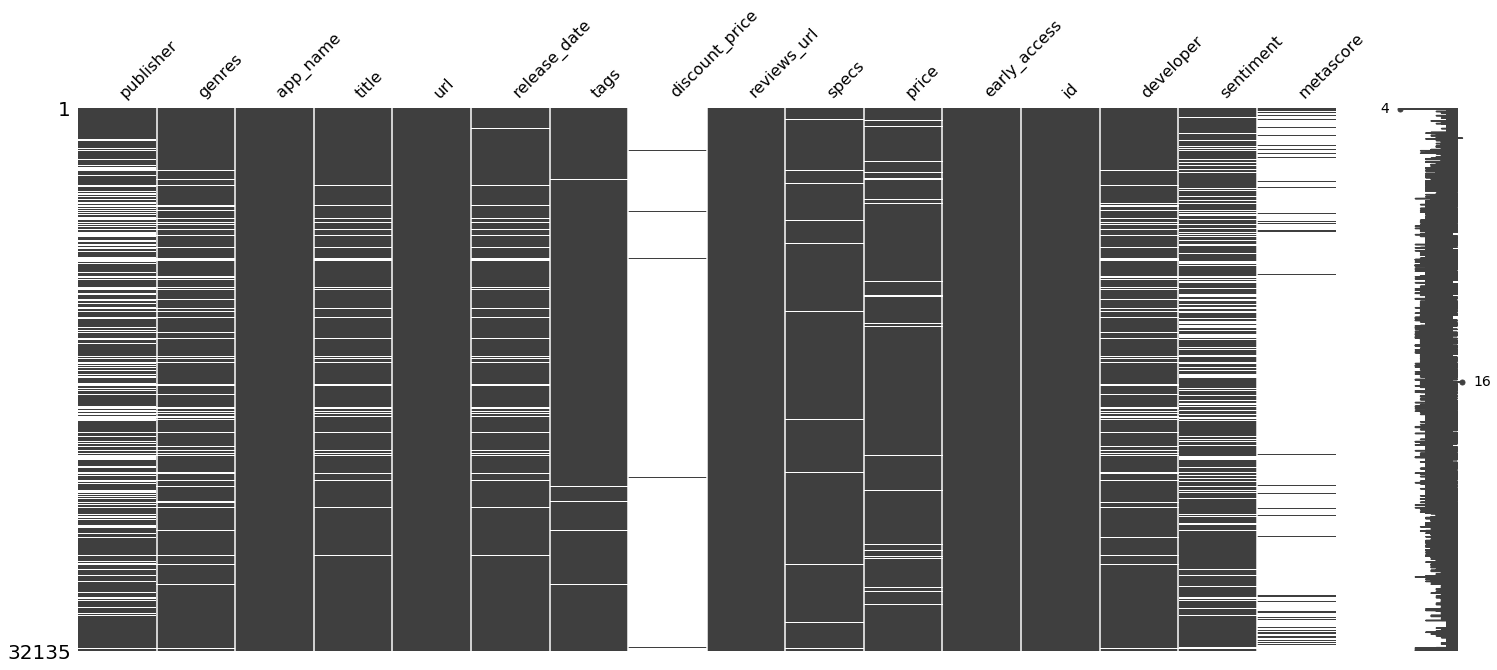

In [13]:
msno.matrix(data_games)

In [14]:
data_games.shape

(32135, 16)

Las columnas a continuación no otorgan valor para el análisis exploratorio, se incluyen algunas con valores faltantes superior al 90% del total de los datos. El resto de columnas no incluidas aqui servirán para un posterior análisis exploratorio.

In [15]:
data_games.drop(columns=['title', 'discount_price', 'reviews_url',
                         'early_access', 'developer', 'sentiment', 'metascore'], inplace=True)

In [16]:
data_games.isna().sum()*100/len(data_games)

publisher       25.056792
genres          10.216275
app_name         0.006224
url              0.000000
release_date     6.432239
tags             0.507235
specs            2.084954
price            4.285047
id               0.006224
dtype: float64

##### Videjuegos con nombre faltante:

El nombre de la aplicación es importante a la hora de conocer que aplicación se va a recomendar

In [17]:
data_games[data_games.app_name.isna()]

,publisher,genres,app_name,url,release_date,tags,specs,price,id
74,NaN,NaN,NaN,http://store.steampowered.com/,NaN,NaN,NaN,19.99,NaN
2580,NaN,"[Action, Indie]",NaN,http://store.steampowered.com/app/317160/_/,2014-08-26,"[Action, Indie]","[Single-player, Game demo]",NaN,317160


* Al parecer hay un videojuego que no existe (indice 74), se puede verificar examinando su url la cual no está compuesta por id ni nombre del videojuego.  
* Con el segundo registro obtenido, al acceder a su url (http://store.steampowered.com/app/317160/_/) parece ser una versión Demo gratuita, no aparece el titulo, ni imagenes adjuntas pero tiene reviews de algunos usuarios, en la imagen portada de se logra apreciar su nombre ("Duet").  
Al consultar otro videojuego con este mismo nombre encontramos la versión completa de pago con los datos completos.

In [18]:
data_games.query('app_name=="Duet"')

,publisher,genres,app_name,url,release_date,tags,specs,price,id
4103,Kumobius,"[Action, Indie]",Duet,http://store.steampowered.com/app/292600/Duet/,2015-08-03,"[Indie, Action, Minimalist, Great Soundtrack, ...","[Single-player, Steam Achievements, Full contr...",4.99,292600


Asignando nombre de videojuego faltante:

In [19]:
data_games.iloc[2580].app_name = 'Duet'

Aplicando dropna() al dataset con valores faltantes por la columna **"app_name"**

In [20]:
data_games.dropna(subset=['app_name'], inplace=True)
data_games.isna().sum()

publisher       8051
genres          3282
app_name           0
url                0
release_date    2066
tags             162
specs            669
price           1377
id                 1
dtype: int64

##### Videojuegos con ID faltante

El ID del videojuego también es un identificador importante y no se debe ignorar.

In [21]:
data_games[data_games.id.isna()]

,publisher,genres,app_name,url,release_date,tags,specs,price,id
30961,"Warner Bros. Interactive Entertainment, Feral ...","[Action, Adventure]",Batman: Arkham City - Game of the Year Edition,http://store.steampowered.com/app/200260,2012-09-07,"[Action, Open World, Batman, Adventure, Stealt...","[Single-player, Steam Achievements, Steam Trad...",19.99,NaN


Vemos que la url contiene el id faltante y en este caso se obtuvo un solo registro, con un simple _"copy - paste"_ de este id y conociendo el índice se podría solucionar, pero en caso de haber obtenido multiples registros la tarea sería mas tediosa si se hace manualmente. Crear una iteración sobre éstos videojuegos para completar el id es lo mas viable en este caso:

Split basico a una url para obtener el id:

In [22]:
'http://store.steampowered.com/app/200260'.split('app/')[1].split('/')[0]

'200260'

Aplicando la estrategia en un loop:

In [23]:
games_id_nan = data_games[data_games.id.isna()].index
for idx in games_id_nan:
    url = data_games.loc[idx].url
    id_game = url.split('app/')[1].split('/')[0]
    data_games.loc[idx].id = id_game

In [24]:
data_games[data_games.index==30961]

,publisher,genres,app_name,url,release_date,tags,specs,price,id
30961,"Warner Bros. Interactive Entertainment, Feral ...","[Action, Adventure]",Batman: Arkham City - Game of the Year Edition,http://store.steampowered.com/app/200260,2012-09-07,"[Action, Open World, Batman, Adventure, Stealt...","[Single-player, Steam Achievements, Steam Trad...",19.99,200260


In [25]:
data_games.isna().sum()

publisher       8051
genres          3282
app_name           0
url                0
release_date    2066
tags             162
specs            669
price           1377
id                 0
dtype: int64

In [26]:
data_games.shape

(32134, 9)

#### Videojuegos duplicados

Estrategia para eliminar videojuegos duplicados empezando por aquellos cuyo ID sea el mismo.

In [27]:
data_games[data_games.duplicated(
    subset=['id'], keep=False)].sort_values(by='publisher')

,publisher,genres,app_name,url,release_date,tags,specs,price,id
13894,Bethesda Softworks,[Action],Wolfenstein II: The New Colossus,http://store.steampowered.com/app/612880/,2017-10-26,"[Action, FPS, Gore, Violent, Alternate History...","[Single-player, Steam Achievements, Full contr...",59.99,612880
14573,Bethesda Softworks,[Action],Wolfenstein II: The New Colossus,http://store.steampowered.com/app/612880/Wolfe...,2017-10-26,"[Action, FPS, Gore, Violent, Alternate History...","[Single-player, Steam Achievements, Full contr...",59.99,612880
1068,"Warner Bros. Interactive Entertainment, Feral ...","[Action, Adventure]",Batman: Arkham City - Game of the Year Edition,http://store.steampowered.com/app/200260/Batma...,2012-09-07,"[Action, Open World, Batman, Adventure, Stealt...","[Single-player, Steam Achievements, Steam Trad...",19.99,200260
30961,"Warner Bros. Interactive Entertainment, Feral ...","[Action, Adventure]",Batman: Arkham City - Game of the Year Edition,http://store.steampowered.com/app/200260,2012-09-07,"[Action, Open World, Batman, Adventure, Stealt...","[Single-player, Steam Achievements, Steam Trad...",19.99,200260


In [28]:
data_games.drop_duplicates(subset=['id'], ignore_index=True, inplace=True)

In [29]:
data_games.shape

(32132, 9)

In [30]:
data_games.isna().sum()

publisher       8051
genres          3282
app_name           0
url                0
release_date    2066
tags             162
specs            669
price           1377
id                 0
dtype: int64

#### Filtrado de categorías

Se filtrarán aquellas categorías relacionadas a Hardware, Software, vídeos, etc que se encuentran en este dataset procurando dejar únicamente videojuegos válidos para el sistema de recomendación basado en filtro colaborativo. Los registros exentos permanecerán para una recomendación más simple; creemos que aunque al usuario solo le interesen videojuegos tal vez sienta curiosidad por explorar items adicionales que la plataforma Steam ofrece.

* Filtrando géneros y tags faltantes

Seleccionando videojuegos con género y especificación faltante, con éste filtro removemos una gran cantidad de utilidades y los almacenanos en otro dataframe:

In [31]:
isNan_genre_tag = data_games.genres.isna() & data_games.specs.isna()
df_no_games = data_games[isNan_genre_tag]
print(df_no_games.shape)

(383, 9)


In [32]:
df_no_games.sample(frac=.2)

,publisher,genres,app_name,url,release_date,tags,specs,price,id
18469,NaN,NaN,The Unearthing,http://store.steampowered.com/app/440200/The_U...,2017-03-30,"[Movie, Adventure]",NaN,1.99,440200
25222,NaN,NaN,Molly,http://store.steampowered.com/app/403810/Molly/,2014-03-07,"[Comedy, Short, Drama]",NaN,1.99,403810
22967,NaN,NaN,Kindred Spirits on the Roof Drama CD Vol.2,http://store.steampowered.com/app/474230/Kindr...,2016-05-27,"[Anime, Episodic]",NaN,9.99,474230
21434,NaN,NaN,Garden of Words,http://store.steampowered.com/app/518360/Garde...,2013-05-31,"[Movie, Anime]",NaN,3.99,518360
21780,NaN,NaN,Kalen Chock Presents: Approaching Interiors,http://store.steampowered.com/app/519380/Kalen...,2016-08-29,"[Design & Illustration, Tutorial]",NaN,4.99,519380
...,...,...,...,...,...,...,...,...,...
15095,NaN,NaN,Portrait Drawing Fundamentals Course,http://store.steampowered.com/app/712540/Portr...,2012-11-30,[Tutorial],NaN,59.99,712540
14586,NaN,NaN,WorldEnd: What Do You Do at the End of the Wor...,http://store.steampowered.com/app/683010/World...,2017-10-26,"[Episodic, Anime]",NaN,1.99,683010
3394,NaN,NaN,From Bedrooms to Billions,http://store.steampowered.com/app/342430/From_...,2015-03-31,"[Game Development, Documentary, Retro, Gaming]",NaN,9.99,342430
5140,NaN,NaN,Robotpencil Presents: Lighting Tools and Tips,http://store.steampowered.com/app/414840/Robot...,2016-01-14,"[Design & Illustration, Tutorial]",NaN,19.99,414840


In [33]:
data_games = data_games[~isNan_genre_tag]

In [34]:
data_games.shape

(31749, 9)

In [35]:
data_games.isna().sum()

publisher       7668
genres          2899
app_name           0
url                0
release_date    2066
tags             155
specs            286
price           1369
id                 0
dtype: int64

* Rellenando genres, tags y specs faltantes con una lista vacia, para que las operaciones aplicadas a éstas columnas sea más fácil

In [36]:
for col in ['genres', 'tags', 'specs']:
    data_games[col].fillna({i: [] for i in data_games.index}, inplace=True)

In [37]:
data_games.isna().sum()

publisher       7668
genres             0
app_name           0
url                0
release_date    2066
tags               0
specs              0
price           1369
id                 0
dtype: int64

* Obteniendo categorias únicas para genres, tags y specs en cada registro:

In [38]:
#Todas las categorías
data_games['categories'] = data_games['genres'] + data_games['tags'] + data_games['specs']

#Obtencion de categorías únicas
data_games['categories'] = [np.unique(cat) for cat in data_games.categories]

#Removiendo caracteres, ej: Single-player singleplayer, Multiplayer, MultiPlayer, Multi-Player
data_games['categories'] = [[re.sub(r'[^\w\s]', '', subcat).lower() for subcat in cat] for cat in data_games.categories]

* Obteniendo categorías válidas (manualmente):

In [39]:
np.unique(list(itertools.chain(*data_games.categories)))

array(['1980s', '1990s', '25d', '2d', '2d fighter', '360 video',
       '3d platformer', '3d vision', '4 player local', '4x', '6dof',
       'abstract', 'accounting', 'action', 'action rpg',
       'actionadventure', 'adventure', 'agriculture', 'aliens',
       'alternate history', 'america', 'animation  modeling',
       'animation amp modeling', 'anime', 'arcade', 'arena shooter',
       'artificial intelligence', 'assassin', 'asynchronous multiplayer',
       'atmospheric', 'audio production', 'base building',
       'based on a novel', 'basketball', 'batman', 'beat em up',
       'benchmark', 'bikes', 'blood', 'board game', 'bowling', 'building',
       'bullet hell', 'bullet time', 'capitalism', 'captions available',
       'card game', 'cartoon', 'cartoony', 'casual',
       'character action game', 'character customization', 'chess',
       'choices matter', 'choose your own adventure', 'cinematic',
       'city builder', 'classbased', 'classic', 'clicker', 'cold war',
       'c

* Verificando manualmente algunas de éstas categorías: En éste paso, realizamos una tediosa y necesaria labor de identificar cada una de estas categorías y aproximar su validez para un videojuego. Las categorías recoletadas se listan debajo.

In [40]:
INVALID_CATEGORIES = ['photo editing', 'game development', 'documentary', 'video production', 'tutorial', 'software',
                      'movie', 'software training', 'soundtrack', 'utilities', 'accounting', 'downloadable content']

La categoría "downloadable content", por ejemplo, está relacionada con packs de videojuegos (Verificado al acceder a la URL). Es decir, en este dataset encontramos videojuegos con sus packs respectivos y éstos últimos son elementos que no deberían estar en el sistema de recomendación objetivo.
Para evidenciar lo dicho anteriormente, filtramos por la categoria de ejemplo y notamos a simple vista que algunos registros son complementos de un videojuego con nombre "SNOW" e identificador "244930".

In [41]:
def getTuplesPandas(search_list):
    return [game for game in data_games.itertuples()
            if np.isin(search_list, game.categories).sum() > 0]

In [42]:
pd.DataFrame(getTuplesPandas(['downloadable content'])).head(7)

,Index,publisher,genres,app_name,url,release_date,tags,specs,price,id,categories
0,6,NaN,"[Free to Play, Indie, Simulation, Sports]",SNOW - All Access Basic Pass,http://store.steampowered.com/app/774276/SNOW_...,2018-01-04,"[Free to Play, Indie, Simulation, Sports]","[Single-player, Multi-player, Online Multi-Pla...",9.99,774276,"[crossplatform multiplayer, downloadable conte..."
1,7,Poppermost Productions,"[Free to Play, Indie, Simulation, Sports]",SNOW - All Access Pro Pass,http://store.steampowered.com/app/774277/SNOW_...,2018-01-04,"[Free to Play, Indie, Simulation, Sports]","[Single-player, Multi-player, Online Multi-Pla...",18.99,774277,"[crossplatform multiplayer, downloadable conte..."
2,8,Poppermost Productions,"[Free to Play, Indie, Simulation, Sports]",SNOW - All Access Legend Pass,http://store.steampowered.com/app/774278/SNOW_...,2018-01-04,"[Free to Play, Indie, Simulation, Sports]","[Single-player, Multi-player, Online Multi-Pla...",29.99,774278,"[crossplatform multiplayer, downloadable conte..."
3,16,Poppermost Productions,"[Free to Play, Indie, Simulation, Sports]",SNOW - Starter Pack,http://store.steampowered.com/app/774271/SNOW_...,2018-01-03,"[Free to Play, Indie, Simulation, Sports]","[Single-player, Multi-player, Online Multi-Pla...",14.99,774271,"[crossplatform multiplayer, downloadable conte..."
4,17,Apillo,"[Adventure, Casual, Indie, Simulation, Strategy]",The first thrust of God - All Aircrafts,http://store.steampowered.com/app/773690/The_f...,2018-01-03,"[Strategy, Adventure, Indie, Casual, Simulatio...","[Single-player, Downloadable Content, Steam Ac...",1.99,773690,"[adventure, casual, downloadable content, indi..."
5,18,Poppermost Productions,"[Free to Play, Indie, Simulation, Sports]",SNOW - Lifetime Pack,http://store.steampowered.com/app/774279/SNOW_...,2018-01-03,"[Free to Play, Indie, Simulation, Sports]","[Single-player, Multi-player, Online Multi-Pla...",59.99,774279,"[crossplatform multiplayer, downloadable conte..."
6,23,FrozenPepper,"[Racing, Simulation, Sports]",RC Plane 3 - Canyon Scenario,http://store.steampowered.com/app/775880/RC_Pl...,2017-12-22,"[Simulation, Racing, Sports]","[Single-player, Downloadable Content, Steam Ac...",2.99,775880,"[downloadable content, partial controller supp..."


Buscando el videojuego SNOW:

In [43]:
data_games.query('id=="244930"')

,publisher,genres,app_name,url,release_date,tags,specs,price,id,categories
1647,Poppermost Productions,"[Free to Play, Indie, Simulation, Sports, Earl...",SNOW,http://store.steampowered.com/app/244930/SNOW/,2013-10-10,"[Early Access, Sports, Free to Play, Multiplay...","[Single-player, Multi-player, Online Multi-Pla...",Free to Play,244930,"[action, adventure, casual, controller, crossp..."


Esto confirma la existencia de muchos complementos, la estrategia mencionada al inicio es separar todos los complementos, utilidades y herramientas adicionales en otro dataset para realizar un análisis con ellos.

* Sumando al dataframe aquellos ítems de esas categorías:

In [44]:
df_no_games = df_no_games.append(getTuplesPandas(INVALID_CATEGORIES))

In [45]:
df_no_games.shape

(14146, 11)

In [46]:
df_no_games.columns

Index(['publisher', 'genres', 'app_name', 'url', 'release_date', 'tags',
       'specs', 'price', 'id', 'Index', 'categories'],
      dtype='object')

In [47]:
df_no_games.drop('Index', axis=1, inplace=True)

In [48]:
print(df_no_games.shape)
df_no_games.head()

(14146, 10)


,publisher,genres,app_name,url,release_date,tags,specs,price,id,categories
26,NaN,NaN,Robotpencil Presents: Understanding 3D for Con...,http://store.steampowered.com/app/777910/Robot...,2018-01-03,"[Design & Illustration, Tutorial]",NaN,4.99,777910,NaN
2476,NaN,NaN,Us and the Game Industry,http://store.steampowered.com/app/360290/Us_an...,2014-07-28,"[Indie, Game Development, Documentary, Gaming]",NaN,4.99,360290,NaN
2690,NaN,NaN,Double Action Dedicated Server,http://store.steampowered.com/app/317800/Doubl...,2014-10-01,[Free to Play],NaN,NaN,317800,NaN
3394,NaN,NaN,From Bedrooms to Billions,http://store.steampowered.com/app/342430/From_...,2015-03-31,"[Game Development, Documentary, Retro, Gaming]",NaN,9.99,342430,NaN
3478,NaN,NaN,Mortal Kombat: Legacy II,http://store.steampowered.com/app/362280/Morta...,2013-09-26,"[Fighting, Action, Episodic, Free to Play]",NaN,Free,362280,NaN


* Filtrando videojuegos:

In [49]:
data_games = data_games[~data_games.id.isin(df_no_games.id)]

In [50]:
data_games.shape

(17986, 10)

Eliminando columnas "specs" y "tags":

In [51]:
data_games.drop(['specs', 'tags'], inplace=True, axis=1)

Ahora, rellenando con valores faltantes las listas vacías en columna "genres":

In [52]:
data_games['genres'] = data_games['genres'].apply(lambda x: np.nan if len(x) == 0 else x)

In [53]:
data_games.isna().sum()

publisher       2097
genres          2018
app_name           0
url                0
release_date    1922
price            920
id                 0
categories         0
dtype: int64

#### Procesamiento de precios

La columna "price" esta conforma por valores numéricos y categóricos:

In [54]:
category_prices = lambda x: np.unique(np.array([i for i in list(x) if type(i) == str]))

* Categoría de precios

In [55]:
category_prices(data_games.price)

array(['Free', 'Free Demo', 'Free HITMAN™ Holiday Pack', 'Free Mod',
       'Free To Play', 'Free to Play', 'Play WARMACHINE: Tactics Demo',
       'Play for Free!', 'Play the Demo', 'Third-party'], dtype='<U29')

* Categoría de precios dataset de utilidades:

In [56]:
category_prices(df_no_games.price)

array(['Free', 'Free Movie', 'Free To Play', 'Free to Play',
       'Free to Try', 'Free to Use', 'Install Now', 'Install Theme',
       'Play Now', 'Starting at $449.00', 'Starting at $499.00',
       'Third-party'], dtype='<U19')

Creando nuevas categorías para la columna precio, actualmente contamos con valores numéricos y categóricos, la única categoría que se transformará a "paid" es "Starting at $499.00" del dataset de utilidades, el resto quedará como "free".  
Con la siguiente función se procesarán éstas categorías y al mismo tiempo, los valores faltantes se convertirán a "paid" (tal vez algunos sean videojuegos gratuitos pero ésto no tiene gran impacto en el análisis).

In [57]:
def transform_prices(df):
    df['category_price'] = df.price.apply(
        lambda p: 'paid' if (type(p) == float or p.startswith('Starting')) else 'free')
    df.drop('price', axis=1, inplace=True)

In [58]:
transform_prices(data_games)
data_games.head()

,publisher,genres,app_name,url,release_date,id,categories,category_price
0,Kotoshiro,"[Action, Casual, Indie, Simulation, Strategy]",Lost Summoner Kitty,http://store.steampowered.com/app/761140/Lost_...,2018-01-04,761140,"[action, casual, indie, simulation, singleplay...",paid
1,"Making Fun, Inc.","[Free to Play, Indie, RPG, Strategy]",Ironbound,http://store.steampowered.com/app/643980/Ironb...,2018-01-04,643980,"[2d, board game, card game, character customiz...",free
2,Poolians.com,"[Casual, Free to Play, Indie, Simulation, Sports]",Real Pool 3D - Poolians,http://store.steampowered.com/app/670290/Real_...,2017-07-24,670290,"[casual, free to play, inapp purchases, indie,...",free
3,彼岸领域,"[Action, Adventure, Casual]",弹炸人2222,http://store.steampowered.com/app/767400/2222/,2017-12-07,767400,"[action, adventure, casual, singleplayer]",paid
4,NaN,NaN,Log Challenge,http://store.steampowered.com/app/773570/Log_C...,NaN,773570,"[action, casual, full controller support, htc ...",paid


In [59]:
transform_prices(df_no_games)
df_no_games.head()

,publisher,genres,app_name,url,release_date,tags,specs,id,categories,category_price
26,NaN,NaN,Robotpencil Presents: Understanding 3D for Con...,http://store.steampowered.com/app/777910/Robot...,2018-01-03,"[Design & Illustration, Tutorial]",NaN,777910,NaN,paid
2476,NaN,NaN,Us and the Game Industry,http://store.steampowered.com/app/360290/Us_an...,2014-07-28,"[Indie, Game Development, Documentary, Gaming]",NaN,360290,NaN,paid
2690,NaN,NaN,Double Action Dedicated Server,http://store.steampowered.com/app/317800/Doubl...,2014-10-01,[Free to Play],NaN,317800,NaN,paid
3394,NaN,NaN,From Bedrooms to Billions,http://store.steampowered.com/app/342430/From_...,2015-03-31,"[Game Development, Documentary, Retro, Gaming]",NaN,342430,NaN,paid
3478,NaN,NaN,Mortal Kombat: Legacy II,http://store.steampowered.com/app/362280/Morta...,2013-09-26,"[Fighting, Action, Episodic, Free to Play]",NaN,362280,NaN,free


#### Procesamiento de fecha de lanzamiento

En éste apartado, se transformarán algunas fechas del dataset de videojuegos al formato correcto, la columna release_date además de contener fechas de tipo datetime y valores faltantes, tiene valores categóricos del cual es posible convertirlos a datetime gracias a que algunos de ellos siguen el mismo patrón o comportamiento. 
Para el dataset de utilidades, no será necesario éste tipo de tratamiento.

In [60]:
data_games.release_date.value_counts()

2017-10-31    48
2017-09-01    44
2017-12-01    44
2017-12-15    40
2017-09-15    40
              ..
2009-01-13     1
2003-12-31     1
2012-06-07     1
2005-07-12     1
2013-01-12     1
Name: release_date, Length: 3220, dtype: int64

La siguiente función servirá para obtener aquellos valores que no corresponden a fechas válidas para poder examinar los valores categóricos:

In [61]:
def isDateValid(x): 
    try:
        return datetime.datetime.strptime(x, '%Y-%m-%d')        
    except:
        return False

In [62]:
invalid_date_games = data_games.query('release_date.notna()', engine='python')
invalid_date_games = pd.DataFrame([i for i in invalid_date_games.itertuples() 
                                   if not isDateValid(i.release_date)])
invalid_date_games.release_date

0            Soon..
1              2017
2         Beta测试已开启
3          Jun 2009
4          Oct 2010
           ...     
247      15.01.2018
248        Q1, 2018
249     Coming Soon
250            2016
251    January 2018
Name: release_date, Length: 252, dtype: object

De las categorías mostradas, las que tienen el nombre del mes (completo o abreviado) y año es posible convertirlas. El nombre de la temporada y el año presentan el mismo caso. **Ejemplos: Nov 2020, November 2020, Winter 2020, Summer 2020...**

* Para empezar, la función a continuación retorna el número del mes basado en el nombre, gracias a una de las librerías incluidas en Python.

In [63]:
def get_month(month):
    if len(month) > 3:
        return strptime(month, '%B').tm_mon
    else:
        return strptime(month, '%b').tm_mon

In [64]:
print('Noviembre:', get_month('Nov'))
print('Noviembre:', get_month('November'))
print('Abril:', get_month('Apr'))
print('Abril:', get_month('April'))

Noviembre: 11
Noviembre: 11
Abril: 4
Abril: 4


Las temporadas se definirarán según el país, en éste caso es Estados Unidos. El diccionario contiene el nombre de la temporada y el mes en que inicia:

In [65]:
SEASONS = {'Winter': 12, 'Summer': 7, 'Fall': 10, 'Spring': 4}

* Ésta función obtiene una fecha como variable categórica y la transforma a datetime, si no corresponde al patron detectado la convierte a valor faltante. El resto de fechas no están definidas por un comportamiento, por lo tanto no es posible transformarlas una por una, y son mas de 100 categorías.

In [66]:
def get_date(date_sring):
    try:
        sep = date_sring.split()
        # Primero verifica si es una temporada
        if sep[0] in SEASONS.keys():
            return datetime.datetime(year=int(sep[1]), month=SEASONS.get(sep[0]), day=1).date()

        # Sino, utiliza la función anterior para obtener el número del mes a partir del nombre.
        return datetime.datetime(year=int(sep[1]), month=get_month(sep[0]), day=1).date()
    except:
        # Retorna valor faltante si no se cumplen los dos casos, no es posible hacer más magia!!
        return np.nan

Ejemplo:

In [67]:
example_date = 'Nov 2020'
print('Noviembre', get_date(example_date))

example_date = 'November 2020'
print('Noviembre', get_date(example_date))

example_date = 'Summer 2020'
print('Verano', get_date(example_date))

example_date = 'Winter 2020'
print('Winter', get_date(example_date))

Noviembre 2020-11-01
Noviembre 2020-11-01
Verano 2020-07-01
Winter 2020-12-01


* Transformando fechas categóricas:

In [68]:
invalid_date_games.release_date = invalid_date_games.release_date.apply(lambda x: f'{get_date(x)}')
invalid_date_games.release_date

0             nan
1             nan
2             nan
3      2009-06-01
4      2010-10-01
          ...    
247           nan
248           nan
249           nan
250           nan
251    2018-01-01
Name: release_date, Length: 252, dtype: object

* Aplicando cambios sobre el dataframe original

In [69]:
invalid_idx = invalid_date_games.Index.values
data_games.loc[invalid_idx,
               'release_date'] = invalid_date_games.release_date.values

* Verificando los cambios en los índices donde previamente existían éstas categorías:

In [70]:
data_games.loc[invalid_idx].head()

,publisher,genres,app_name,url,release_date,id,categories,category_price
10,Qucheza,"[Action, Indie, Simulation, Early Access]",Uncanny Islands,http://store.steampowered.com/app/768570/Uncan...,nan,768570,"[action, early access, indie, simulation, sing...",paid
43,Breakout Studio,"[Indie, Massively Multiplayer, RPG, Early Access]",Life of Rome,http://store.steampowered.com/app/381620/Life_...,nan,381620,"[character customization, crafting, early acce...",paid
44,zha7,"[Adventure, Free to Play, RPG, Early Access]",Idle Adventure,http://store.steampowered.com/app/714020/Idle_...,nan,714020,"[adventure, early access, free to play, mmo, r...",paid
249,Erik Svedäng,"[Adventure, Indie]",Blueberry Garden,http://store.steampowered.com/app/29160/Bluebe...,2009-06-01,29160,"[adventure, indie, puzzle, short, singleplayer]",paid
505,Paradox Interactive,"[RPG, Strategy]",Age of Wonders II: The Wizard's Throne,http://store.steampowered.com/app/61510/Age_of...,2010-10-01,61510,"[4x, classic, fantasy, multiplayer, rpg, singl...",paid


Se ha completado el procedimiento de transformación de fecha de lanzamiento, con ésto es posible realizar un análisis exploratorio que conlleve Series de tiempo.

In [71]:
del invalid_date_games

Finalmente, los valores faltantes resultantes:

In [72]:
data_games.isna().sum()

publisher         2097
genres            2018
app_name             0
url                  0
release_date      1922
id                   0
categories           0
category_price       0
dtype: int64

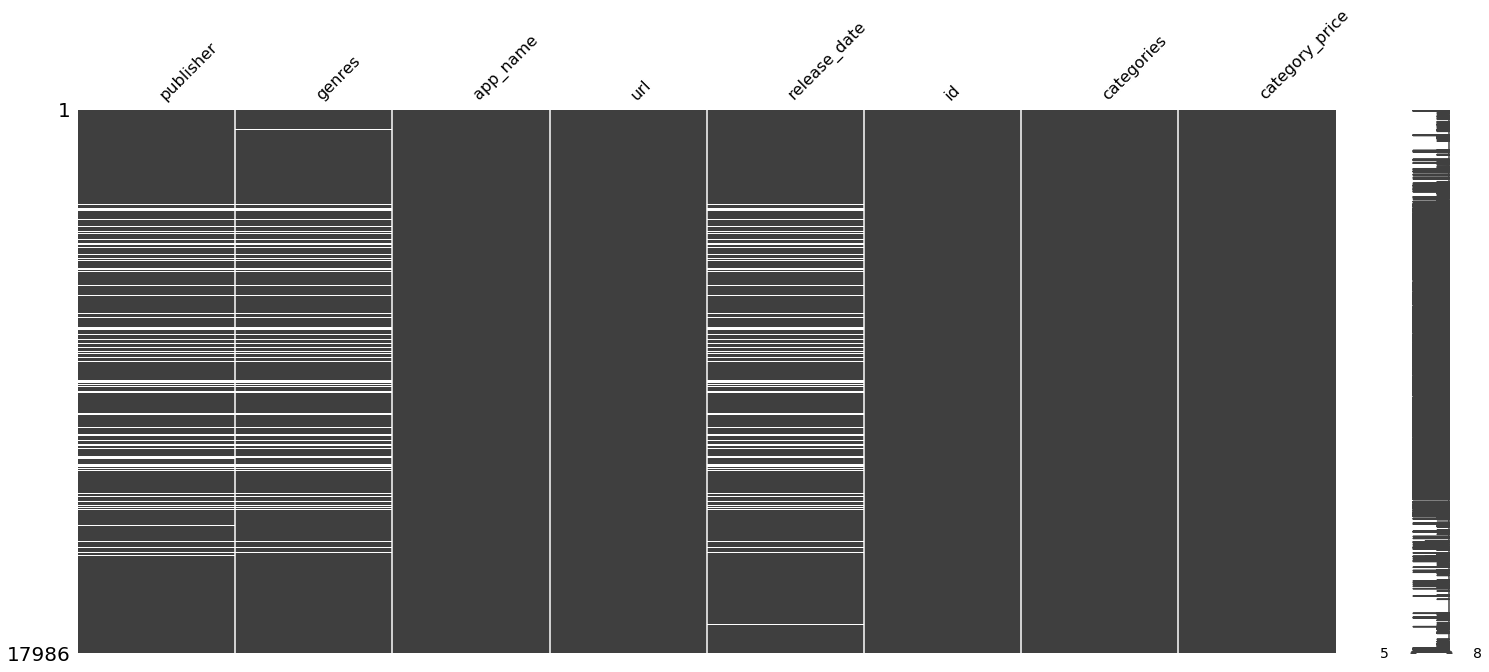

In [73]:
msno.matrix(data_games)

### Preprocesamiento Reviews

In [74]:
data_reviews.head()

,username,hours,product_id,date,text
0,Chaos Syren,0.1,725280,2017-12-17,This would not be acceptable as an entertainme...
1,₮ʜᴇ Wᴀʀᴛᴏɴ,51.1,328100,2017-12-27,looks like a facebook game
2,hello?<,14.6,328100,2017-10-16,Better than Minecraft
3,Cyderine916,5.0,35140,2018-01-04,I love and idolized Batman and this game is Ma...
4,DarklyThinking,16.6,35140,2018-01-04,Still worth playing in 2018.\nProbably my favo...


In [75]:
data_reviews.shape

(7793069, 5)

#### Reviews duplicados (Todos los campos)

Se analiza si existen registros duplicados en el dataset:

In [76]:
duplicated = data_reviews[data_reviews.duplicated()]
duplicated.shape

(831833, 5)

Se confirma la existencia registros duplicados, ahora se detalla un usuario aleatorio de éstos registros:

In [77]:
duplicated.head()

,username,hours,product_id,date,text
2435,Foggy Dreamer,2.2,308040,2017-11-04,PROS:\n- Beautiful visuals and art\n- Decent p...
2632,little gamer64,20.5,271590,2018-01-04,I love this game
3264,Space_Wafer,7.4,427730,2017-12-31,So fun
3498,xanderwhovian,25.5,8880,2014-08-27,"freedom force is an absolutely amazing game, i..."
4028,feel it break,53.6,61700,2017-05-30,"Great and unique gameplay, lovely comic style ..."


Para probar, se selecciona el usuario **"feel it break"**

In [78]:
data_reviews[data_reviews.username == 'feel it break']

,username,hours,product_id,date,text
3880,feel it break,53.6,61700,2017-05-30,"Great and unique gameplay, lovely comic style ..."
4028,feel it break,53.6,61700,2017-05-30,"Great and unique gameplay, lovely comic style ..."
179401,feel it break,14.5,48700,2017-12-30,Well the first few hours into the game I had a...
3498769,feel it break,3.1,435480,2017-12-07,What a f***ing piece of turd of a game this is...
5340520,feel it break,323.5,97330,2017-10-12,Of all the Magic Games that came out and that ...
5518204,feel it break,469.0,316010,2016-12-11,Pro: You can build own magic decks\nCons: .......
6861873,feel it break,56.7,204450,2017-10-12,"Amazing game, very fast paced, stylish, combat..."


En los 2 primeros registros de esta búsqueda se evidencia error de los datos, misma cantidad de horas, id de videojuego y fecha. Por lo tanto es razonable eliminar éstos registros.

In [79]:
data_reviews.drop_duplicates(inplace=True, ignore_index=True)

In [80]:
data_reviews.shape

(6961236, 5)

In [81]:
data_reviews.isna().sum()

username          0
hours         25941
product_id        0
date              0
text              0
dtype: int64

#### Reviews duplicados (Username y product_id)

Habiendo eliminado registros duplicados, nos queda realizar un tratamiento especial a aquellos usuarios que han comentado un videojuego más de una vez, la acción a ejecutar consiste en dejar el ultimo review de un usuario a un videojuego mediante la fecha.

Usuarios con más de un review a un videojuego:

In [82]:
repeated_reviews = data_reviews[data_reviews.duplicated(
    subset=['username', 'product_id'], keep=False)].sort_values(by='username')

In [83]:
print('Reviews del mismo usuario al mismo videojuego:', repeated_reviews.shape[0])

Reviews del mismo usuario al mismo videojuego: 121801


In [84]:
repeated_reviews.head()

,username,hours,product_id,date,text
4441474,!?,1.2,206210,2014-04-08,After all this time still can't play this beca...
4435144,!?,3.2,206210,2014-07-01,Hard to get trading cards
3526482,#1,11.2,440,2015-01-02,✰✰✰✰✰
3500502,#1,13.2,440,2015-09-15,"This game allows hours of fun, hundreds of dif..."
4719243,#GWForJulvärd2018,129.4,346110,2017-09-03,"grinding, grinding and more grinding. to get f..."


El usuario "!?" ha hecho dos comentarios al mismo videojuego (206210), el resultado entonces sería el último comentario realizado.

#### Últimos reviews por fecha

In [85]:
# Para traer todas las columnas. Tarda mas!!
unrepeated_reviews = data_reviews.sort_values(
    by='date', ascending=False).drop_duplicates(subset=['username', 'product_id'])

# unrepeated_reviews = data_reviews.groupby(
#    ['username', 'product_id'], as_index=False).date.max()

Verificando:

In [86]:
unrepeated_reviews.query('username=="!?" & product_id=="206210"')

,username,hours,product_id,date,text
4435144,!?,3.2,206210,2014-07-01,Hard to get trading cards


In [87]:
data_reviews = unrepeated_reviews.copy()

#Liberando espacio en memoria
del repeated_reviews
del unrepeated_reviews

In [88]:
data_reviews.isna().sum()

username          0
hours         25741
product_id        0
date              0
text              0
dtype: int64

In [89]:
data_reviews.shape

(6889728, 5)

#### Tratamiento Horas faltantes

Vemos que las horas faltantes son muy pocas, con solo calcular el promedio de las horas por cada usuario sería suficiente.

In [90]:
data_reviews.hours.fillna(data_reviews.groupby('username').hours.transform('mean'), inplace=True)

In [91]:
data_reviews.isna().sum()

username         0
hours         4264
product_id       0
date             0
text             0
dtype: int64

Aún existen horas faltantes, verémos que ocurre:

In [92]:
data_reviews[data_reviews.hours.isna()]

,username,hours,product_id,date,text
708088,n4p4l44,NaN,353370,2018-01-05,I chose to buy the Steam Controller over an XB...
5300404,Drunk3n,NaN,353380,2018-01-04,"Great, solves some casual gaming in the sofa.\..."
5300281,floodofnoise,NaN,353380,2018-01-04,This thing is incredible! I purchased one of t...
5300282,Mephisto Felis,NaN,353380,2018-01-04,That thing works amazing i love it to and for ...
708160,Ninja dos Bunnyhop,NaN,353370,2018-01-04,The lack of a seccond analog stick is a proble...
...,...,...,...,...,...
644963,aden_00,NaN,17700,2010-11-27,Great if your looking for a light milsim. and ...
2214784,func_door,NaN,15100,2010-11-22,probably the worst game I am ashamed to have l...
6339980,ChicoFuerte,NaN,4500,2010-11-19,Must-play FPS RPG
3151519,OhMe,NaN,2280,2010-11-19,This game is about big labyrinthic maps and ca...


Explorando algunos usuarios de ésta búsqueda:

In [93]:
USERNAMES = ['catsquad3', 'cardenas1149', 'MarbleMania']
data_reviews.query('username in @USERNAMES')

,username,hours,product_id,date,text
3421965,catsquad3,NaN,440,2017-06-28,rrrrrrr
293527,cardenas1149,NaN,271590,2017-06-17,I recently spent a little over $1200 for a gam...
3449101,MarbleMania,NaN,440,2017-01-09,7/3 would recommend


Aquí se demuestra que éstos usuarios solo han hecho review a un solo videojuego y no registran horas de juego. Por lo tanto, la única alternativa faltante es rellenarlos con el promedio de horas del id del videojuego en el que estuvieron interesados:

In [94]:
data_reviews.hours.fillna(data_reviews.groupby('product_id').hours.transform('mean'), inplace=True)

In [95]:
data_reviews.isna().sum()

username      0
hours         3
product_id    0
date          0
text          0
dtype: int64

In [96]:
data_reviews[data_reviews.hours.isna()]

,username,hours,product_id,date,text
527380,OGK_Demipimp,NaN,538610,2017-12-18,Its a text file in your gamefolder I like to t...
2447770,ZombieIsBest,NaN,492580,2017-06-24,Do not buy doesn't show up in game waste of money
3298398,BytonMcHawk,NaN,584630,2017-04-20,10/10 worth the second computer monitor after ...


Videojuegos que solo tienen un review con horas faltantes. Rellenando con el promedio total de horas:

In [97]:
data_reviews.hours.fillna(data_reviews.hours.mean(), inplace=True)

In [98]:
data_reviews.isna().sum()

username      0
hours         0
product_id    0
date          0
text          0
dtype: int64

In [99]:
data_reviews.shape

(6889728, 5)

#### Separando reviews

Se separarán en datasets diferentes los reviews de videojuegos y utilidades como se ha mencionado en apartados anteriores:

In [100]:
# Filtrando reviews de videojuegos
data_reviews_game = data_reviews.query('product_id not in @df_no_games.id')

# Filtrando reviews de utilidades (Para exportar)
data_reviews_utilites = data_reviews.query('product_id not in @data_games.id')

In [101]:
# Dataset listo para exportar
data_reviews = data_reviews_game.copy()

del data_reviews_game

In [102]:
print('Reviews games:', data_reviews.shape,
      '- Reviews Utilites:', data_reviews_utilites.shape)

Reviews games: (6796871, 5) - Reviews Utilites: (92857, 5)


### Exportando Datasets

* Dataset de videojuegos:

In [104]:
directory = 'data_processed_games'
data_reviews.to_csv(f'{directory}/data_reviews_games.csv', index=False)
data_games.to_csv(f'{directory}/data_games.csv', index=False)

* Dataset de utilidades:

In [105]:
directory = 'data_processed_utilites'
data_reviews_utilites.to_csv(f'{directory}/data_reviews_utilites.csv', index=False)
df_no_games.to_csv(f'{directory}/data_utilites.csv', index=False)

### Lectura

#### Videojuegos procesados:

* Reviews: Se obliga a que la columna username sea tipo string porque existen usuarios cuyo nombre es "null" o "N/A", y Pandas los convierte a NaN. Ejemplo de usuario "null": https://steamcommunity.com/profiles/76561198170981531/

In [2]:
directory = 'data_processed_games'
data_reviews = pd.read_csv(
    f'{directory}/data_reviews_games.csv', converters={'username': str, 'text': str})
data_reviews.date = pd.to_datetime(data_reviews.date)

* Videojuegos: Al exportar a CSV se pierde el formato de algunos datos, los géneros, tags y specs estaban compuestos por listas, en la sección de Preprocesamiento. En la lectura del archivo, aparecen como String, la siguiente función remueve las comillas simples y los corchetes en los extremos:

In [3]:
def toList(x):
    return x[1:-1].replace("'", '').split(', ') if (x is not np.nan) else nan

Aquí se convierte cada elemento de tag en una lista:

In [4]:
data_games = pd.read_csv(f'{directory}/data_games.csv',
                         converters={
                             'genres': lambda x: toList(x),
                             'tags': lambda x: toList(x),
                             'specs': lambda x: toList(x),
                             'categories': lambda x: toList(x)
                         })
data_games.release_date = pd.to_datetime(data_games.release_date)

In [5]:
data_reviews.dtypes

username              object
hours                float64
product_id             int64
date          datetime64[ns]
text                  object
dtype: object

In [6]:
data_games.dtypes

publisher                 object
genres                    object
app_name                  object
url                       object
release_date      datetime64[ns]
id                         int64
categories                object
category_price            object
dtype: object

In [7]:
data_games.head()

,publisher,genres,app_name,url,release_date,id,categories,category_price
0,Kotoshiro,"[Action, Casual, Indie, Simulation, Strategy]",Lost Summoner Kitty,http://store.steampowered.com/app/761140/Lost_...,2018-01-04,761140,"[action, casual, indie, simulation, singleplay...",paid
1,"Making Fun, Inc.","[Free to Play, Indie, RPG, Strategy]",Ironbound,http://store.steampowered.com/app/643980/Ironb...,2018-01-04,643980,"[2d, board game, card game, character customiz...",free
2,Poolians.com,"[Casual, Free to Play, Indie, Simulation, Sports]",Real Pool 3D - Poolians,http://store.steampowered.com/app/670290/Real_...,2017-07-24,670290,"[casual, free to play, inapp purchases, indie,...",free
3,彼岸领域,"[Action, Adventure, Casual]",弹炸人2222,http://store.steampowered.com/app/767400/2222/,2017-12-07,767400,"[action, adventure, casual, singleplayer]",paid
4,NaN,[],Log Challenge,http://store.steampowered.com/app/773570/Log_C...,NaT,773570,"[action, casual, full controller support, htc ...",paid


In [8]:
data_reviews.head()

,username,hours,product_id,date,text
0,✪ switzerleλve,21.9,220,2018-01-05,The game is extremely immersive and had me on ...
1,RockLass,16.5,435030,2018-01-05,Quite enjoyable even for the long haul. Haven'...
2,Locke Kosta,2.9,232750,2018-01-05,"I gave this game a real shot, but the ♥♥♥♥♥♥ n..."
3,Feena,6.8,344440,2018-01-05,A classic hidden objects game with a good stor...
4,DanVanDam,13.6,404680,2018-01-05,I spent so far a good amount of time with this...


In [9]:
data_reviews.isna().sum()

username      0
hours         0
product_id    0
date          0
text          0
dtype: int64

### Consultas

#### Usuarios únicos

In [10]:
print(f'{len(data_reviews.username.value_counts())} usuarios únicos')

2548509 usuarios únicos


#### Top 10 videojuegos más populares

In [11]:
amount_by_productId = data_reviews.groupby('product_id').product_id.count().reset_index(name='amount')

Merge entre videojuegos y reviews:

In [12]:
reviews_games_amount = pd.merge(amount_by_productId, data_games, left_on='product_id',
                               right_on='id').sort_values(by='amount', ascending=False)
top10 = reviews_games_amount.head(10)

In [13]:
# Valores para mostrar en la leyenda de cada barra
HOVER_DATA_COLUMNS = ['publisher', 'release_date', 'genres', 'category_price']

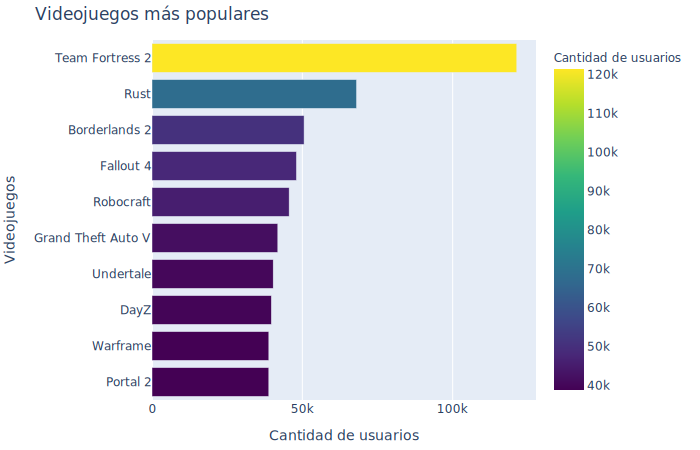

In [14]:
fig = px.bar(top10.sort_values(by='amount'), y='app_name', x='amount', color='amount', title='Videojuegos más populares',
             color_continuous_scale='viridis',
             labels={'app_name': 'Videojuegos',
                     "amount": 'Cantidad de usuarios'},
             hover_data=HOVER_DATA_COLUMNS)
fig.update_layout(
    autosize=False,
    width=800,
    height=500,
    margin=dict(l=20, r=20, t=40, b=10)
)
fig.show('svg')

In [15]:
del top10

#### Videojuegos con más tiempo de juego

In [16]:
hours_by_productId = data_reviews.groupby('product_id', as_index=False).hours.sum()

reviews_games_hours = pd.merge(hours_by_productId, data_games, left_on='product_id',
                               right_on='id').sort_values(by='hours', ascending=False)

hours10 = reviews_games_hours.head(10).sort_values(by='hours')

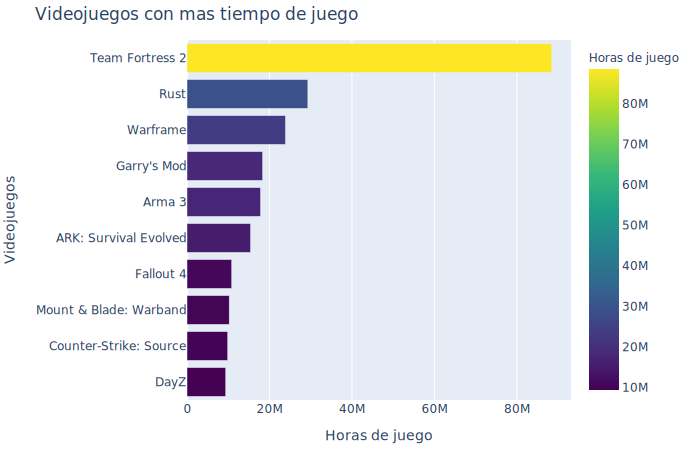

In [17]:
fig = px.bar(data_frame=hours10, y='app_name', x='hours', color='hours', title='Videojuegos con mas tiempo de juego',
             color_continuous_scale='viridis',
             labels={'app_name': 'Videojuegos', "hours": 'Horas de juego'},
             hover_data=HOVER_DATA_COLUMNS)

fig.update_layout(
    autosize=False,
    width=800,
    height=500,
    margin=dict(l=20, r=20, t=40, b=10)
)
fig.show('svg')

In [18]:
#Liberando memoria
del hours_by_productId, reviews_games_hours, hours10

#### Género más popular

In [19]:
all_genres = list(itertools.chain(*data_games.genres))
value, count = np.unique(all_genres, return_counts=True)
order = np.argsort(count)

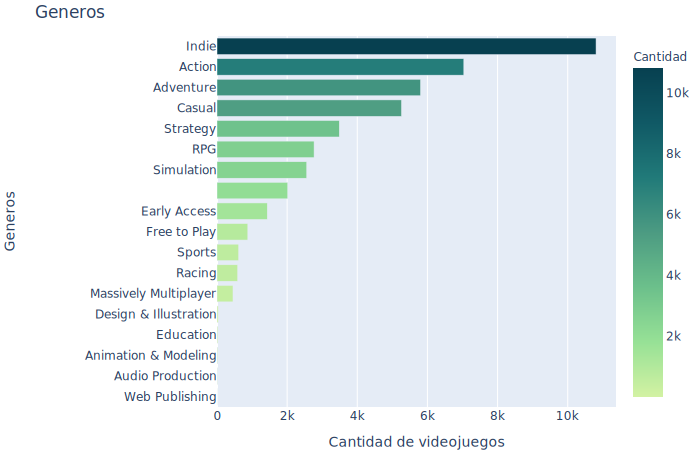

In [20]:
fig = px.bar(x=count[order], y=value[order], color=count[order], color_continuous_scale='emrld', title='Generos', labels={
    'x': 'Cantidad de videojuegos', 'y': 'Generos', 'color': 'Cantidad'})
fig.update_layout(
    autosize=False,
    width=800,
    height=500,
    margin=dict(l=20, r=20, t=3, b=10)
)
fig.show('svg')

#### Videojuegos de pago mas jugados

In [21]:
df_items = data_games.query('category_price=="paid"')
merge_paid_games = pd.merge(amount_by_productId, df_items, left_on='product_id',
                            right_on='id').sort_values(by='amount', ascending=False).head(10)

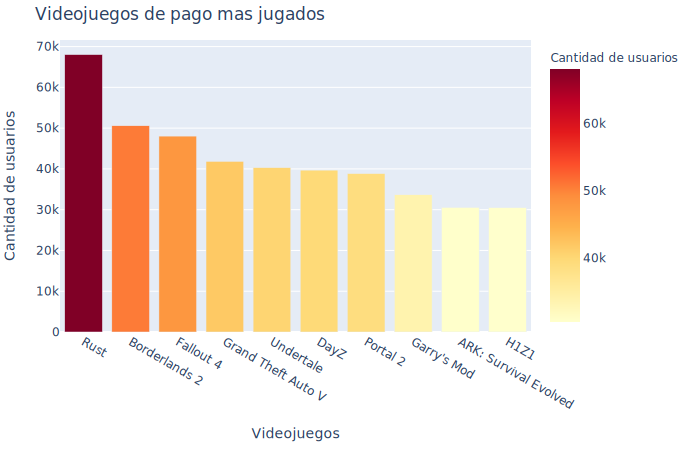

In [22]:
fig = px.bar(data_frame=merge_paid_games, x='app_name', y='amount', title='Videojuegos de pago mas jugados',
             labels={'app_name': 'Videojuegos',
                     'amount': 'Cantidad de usuarios'},
             hover_data=HOVER_DATA_COLUMNS,
             color=merge_paid_games.amount, color_continuous_scale='ylorrd')
fig.update_layout(
    autosize=False,
    width=800,
    height=500,
    margin=dict(l=30, r=20, t=40, b=30)
)
fig.show('svg')

In [23]:
del merge_paid_games

#### Videojuegos gratis mas jugados

In [24]:
df_items = data_games.query('category_price=="free"')
merge_free_games = pd.merge(amount_by_productId, df_items, left_on='product_id',
                            right_on='id').sort_values(by='amount', ascending=False).head(10)

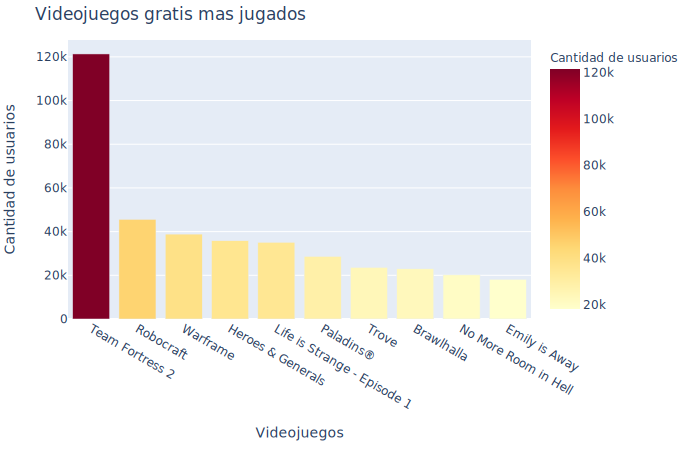

In [25]:
fig = px.bar(data_frame=merge_free_games, x='app_name', y='amount', title='Videojuegos gratis mas jugados',
             labels={'app_name': 'Videojuegos',
                     'amount': 'Cantidad de usuarios', 'color': 'Cantidad'},
             hover_data=HOVER_DATA_COLUMNS,
             color=merge_free_games.amount, color_continuous_scale='ylorrd')

fig.update_layout(
    autosize=False,
    width=800,
    height=500,
    margin=dict(l=20, r=20, t=40, b=30)
)
fig.show('svg')

In [26]:
del merge_free_games

#### Cantidad de usuarios por precio de videojuego

In [27]:
sum_amount_categories = (reviews_games_amount.groupby('category_price').amount.sum() /
                         reviews_games_amount.amount.sum()).to_frame(name='amount').reset_index()

sum_amount_categories.sort_values(by='amount', ascending=False, inplace=True)
sum_amount_categories

,category_price,amount
1,paid,0.81345
0,free,0.18655


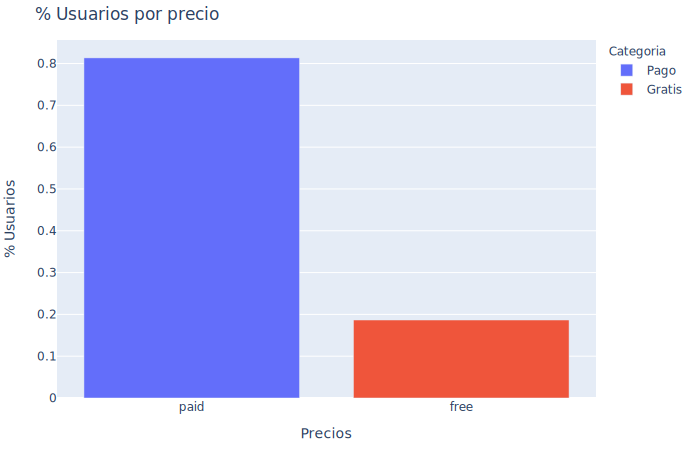

In [28]:
fig = px.bar(sum_amount_categories, x='category_price',
             y='amount', title='% Usuarios por precio', color=['Pago', 'Gratis'],  width=500, height=400,
             labels={'category_price': 'Precios', 'amount': '% Usuarios', 'color': 'Categoria'})
fig.update_layout(
    autosize=False,
    width=500,
    height=400,
    margin=dict(l=20, r=20, t=40, b=30)
)
fig.show('svg')

#### Series de tiempo

##### Lanzamiento de videojuegos

In [29]:
# Creando nueva columna para nombre del mes
games = data_games.assign(
    month_name=data_games.release_date.dt.month_name())

# Frecuencia de cada mes
games = games.month_name.value_counts()

# Pasando objeto value_counts a DataFrame
games = pd.DataFrame({'month_name': games.index, 'amount': games.values})

# Creando el numero del mes
games['n_month'] = pd.to_datetime(
    games.month_name, format='%B', errors='coerce').dt.month

# Ordenando por numero de mes
games.sort_values(by='n_month', inplace=True)

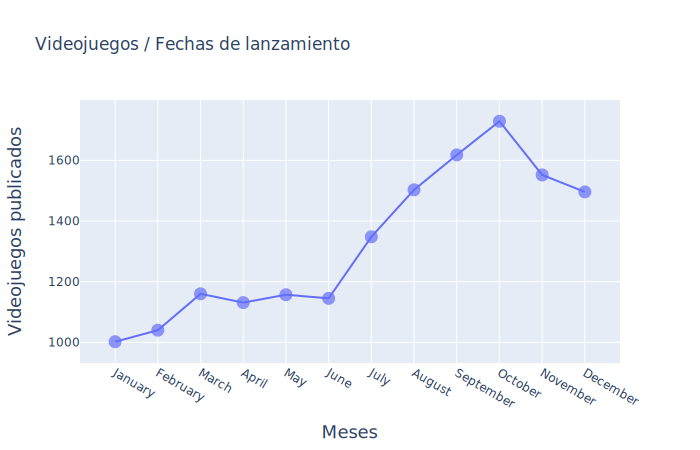

In [30]:
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=games.month_name,
    y=games.amount,
    marker={'size': 13, 'opacity': .7},
))
fig.update_layout(
    title='Videojuegos / Fechas de lanzamiento',
    autosize=False,
    height=500,
    width=950,
    hoverdistance=100,
    spikedistance=1000,
    xaxis=dict(
        title_text='Meses',
        titlefont=dict(size=18),
        showspikes=True,
        spikethickness=2,
        spikedash="dot",
        spikecolor="#999999",
        spikemode="across"),
    yaxis=dict(title_text="Videojuegos publicados", titlefont=dict(size=18))
)
fig.show('svg')

La mayoría de los videojuegos pueden estar siguiendo una estrategia de marketing lo cual explica que el número de publicaciones se acrecenta enormemente en los últimos meses del año.

In [31]:
del games

##### Concentración de usuarios en el año

In [32]:
users_by_month = data_reviews.assign(month_name=data_reviews.date.dt.month_name())

users_by_month = users_by_month.month_name.value_counts()

users_by_month = pd.DataFrame(
    {'month_name': users_by_month.index, 'amount': users_by_month.values})

users_by_month['month_number'] = pd.to_datetime(users_by_month.month_name,
                                                format='%B', errors='coerce').dt.month

users_by_month.sort_values(by='month_number', inplace=True)
users_by_month

,month_name,amount,month_number
4,January,589377,1
8,February,450825,2
9,March,423092,3
11,April,397294,4
10,May,421504,5
2,June,657788,6
3,July,610100,7
5,August,498117,8
7,September,457885,9
6,October,491182,10


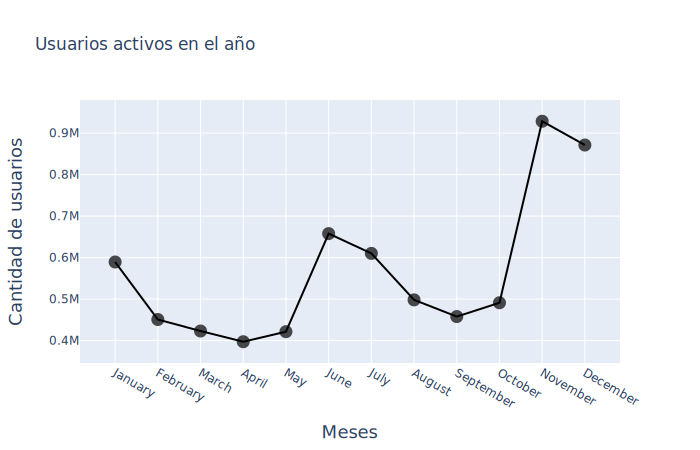

In [33]:
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=users_by_month.month_name,
    y=users_by_month.amount,
    line={'color': '#000000'},
    marker={'size': 13, 'opacity': .7},
))
fig.update_layout(
    title='Usuarios activos en el año',
    autosize=False,
    height=500,
    width=950,
    hoverdistance=100,
    spikedistance=1000,
    xaxis=dict(
        title_text='Meses',
        titlefont=dict(size=18),
        showspikes=True,
        spikethickness=2,
        spikedash="dot",
        spikecolor="red",
        spikemode="across"),
    yaxis=dict(title_text="Cantidad de usuarios", titlefont=dict(size=18))
)
fig.show('svg')

Vemos que se presentan 3 picos en la gráfica: A inicios, mitad y fin de año, lo cual puede estar relacionado a las temporadas de verano e invierno en Estados Unidos, en éstas épocas se concentran la mayoría de usuarios e invierten más horas de su tiempo libre en videojuegos de Steam.

In [34]:
del users_by_month

##### 20 Videojuegos más antiguos

In [35]:
older_games = data_games.drop(['url', 'categories'], axis=1).sort_values(
    by='release_date', ascending=True).head(20)

group_users = data_reviews.query('product_id in @older_games.id')\
    .groupby('product_id').product_id.count().reset_index(name='amount')

older_games = pd.merge(
    older_games, group_users, left_on='id', right_on='product_id')

older_games['year'] = older_games.release_date.dt.year

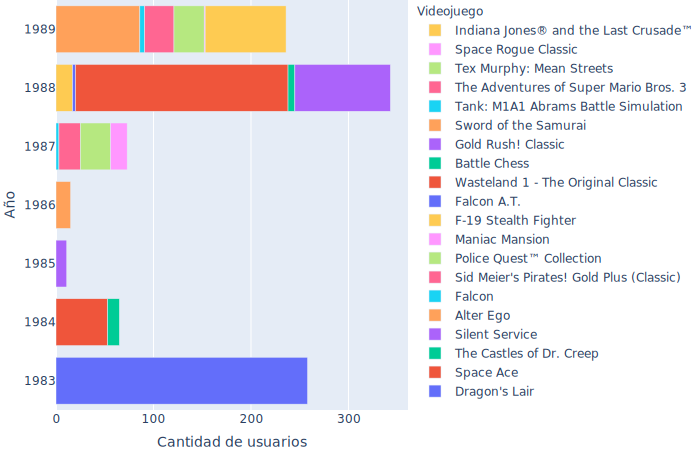

In [36]:
fig = px.bar(data_frame=older_games,
             x='amount',
             y='year',
             color='app_name',
             labels={'year': 'Año', 'amount': 'Cantidad de usuarios',
                     'app_name': 'Videojuego'},
             hover_data=HOVER_DATA_COLUMNS, orientation='h')

fig.update_layout(
    width=850,
    height=5000,
    legend=dict(traceorder='reversed'),
    margin=dict(r=0, t=0, l=0, b=0),
)
fig.show('svg')

El videojuego "Dragon's Lair" a pesar de ser el más antiguo es el que posee mayor cantidad de reviews entre los videojuegos de esa época.

In [37]:
del older_games, group_users

#### Nube de palabras Videojuego más popular

Inicializando variables:

In [38]:
reviews = data_reviews[data_reviews.product_id ==
                       reviews_games_amount.iloc[0].id].text
stopwords = nltk.corpus.stopwords.words('english')
wnl = WordNetLemmatizer()
sentences=[]

In [39]:
for review in reviews:
    # Normalizando
    sent = re.sub('[^a-zA-Z!¡?¿]', ' ', review).strip().lower()
    words = nltk.word_tokenize(sent)
    
    # Aplicando Lematizacion
    words = [wnl.lemmatize(word) for word in words]
    words = [word for word in words if (
        word not in stopwords) and len(word) > 2]    
    words = " ".join(words)
    sentences.append(words)

Formando una sola oración con todas las palabras:

In [40]:
sentences = " ".join(sentences)

Imagen original:

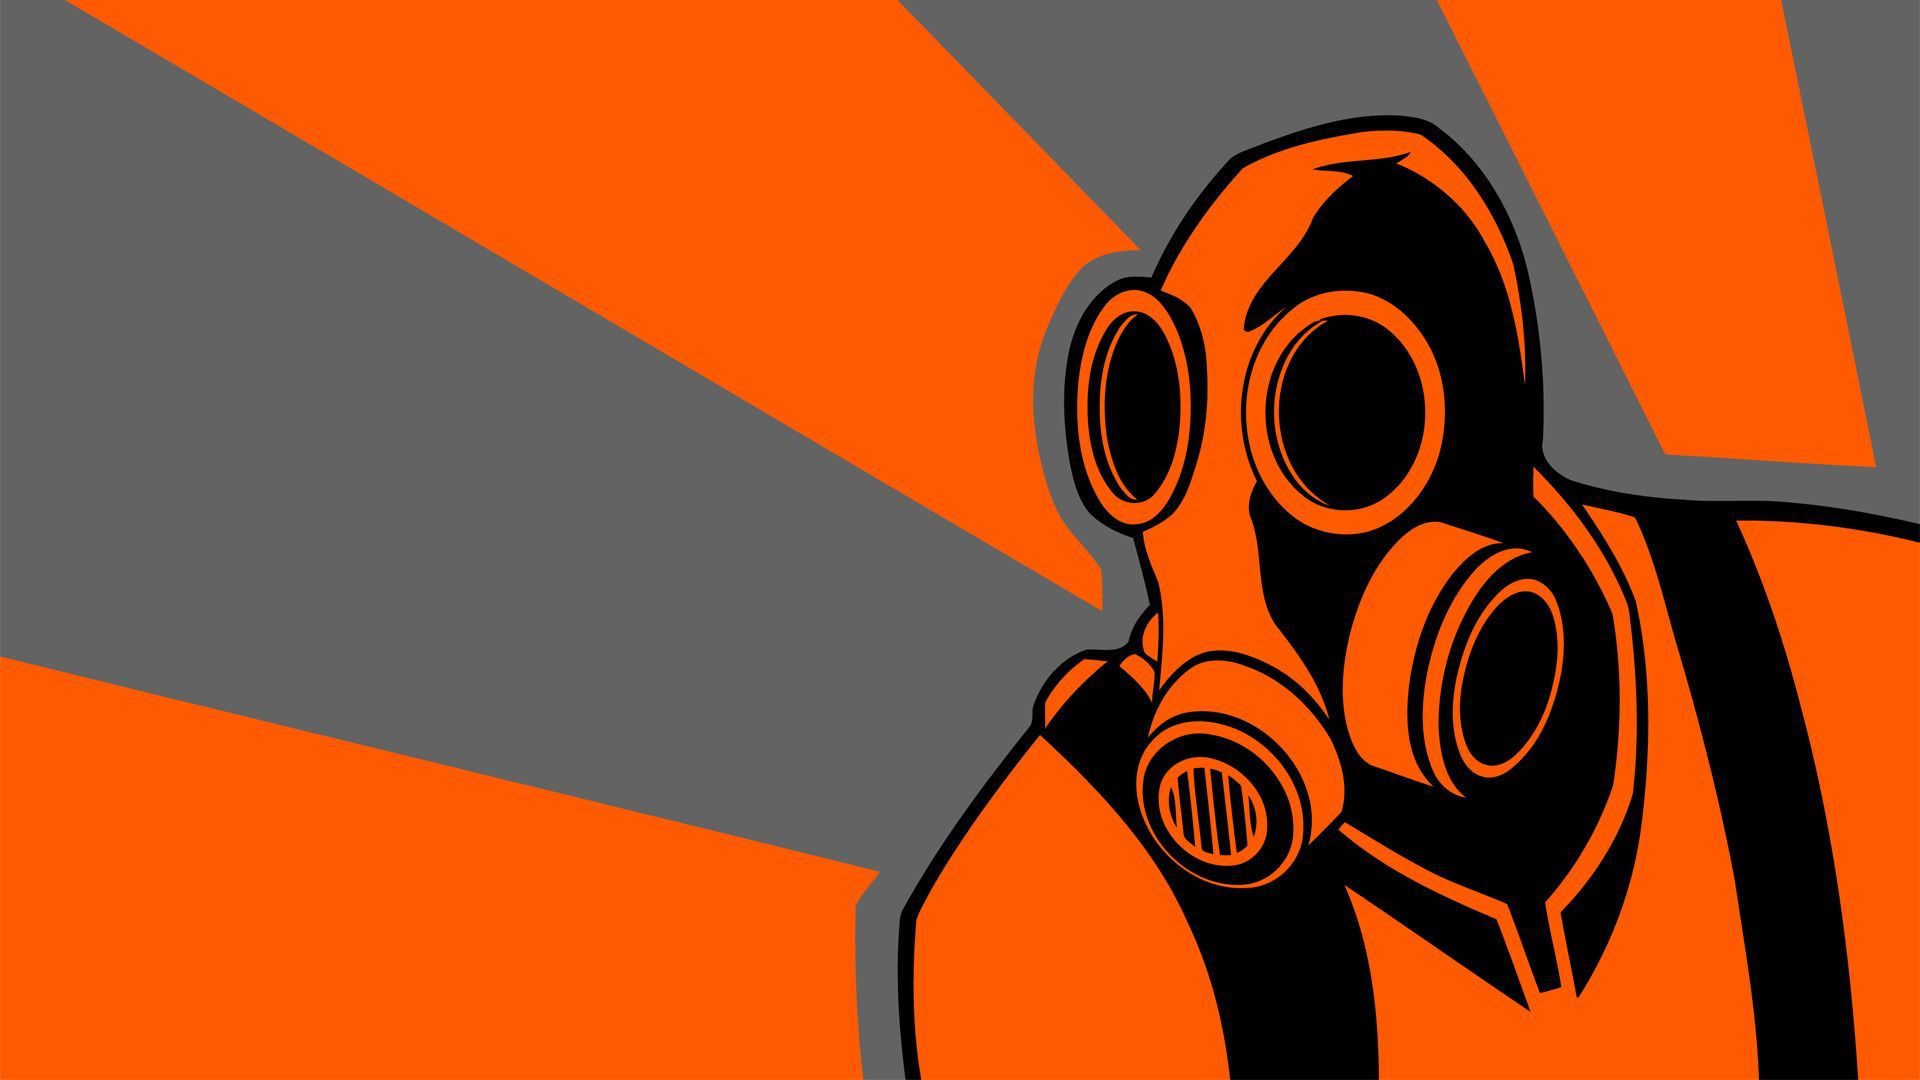

In [369]:
steam_img = Image.open('background.jpg')
steam_img

Procesando imagen para la nube de palabras:

In [370]:
steam_img = np.array(steam_img)[::3, ::3]
steam_mask = steam_img.copy()
steam_mask[steam_mask.sum(axis=2) == 88] = 255

edges = np.mean([gaussian_gradient_magnitude(steam_img[:, :, i]/255, .5)
                 for i in range(3)], axis=0)
steam_mask[edges > .200] = 255

In [371]:
wc = WordCloud(mask=steam_mask, max_words=2800, relative_scaling=.7,
               max_font_size=50, repeat=False, scale=3, contour_color='white')
wc.generate(sentences)

Finalmente:

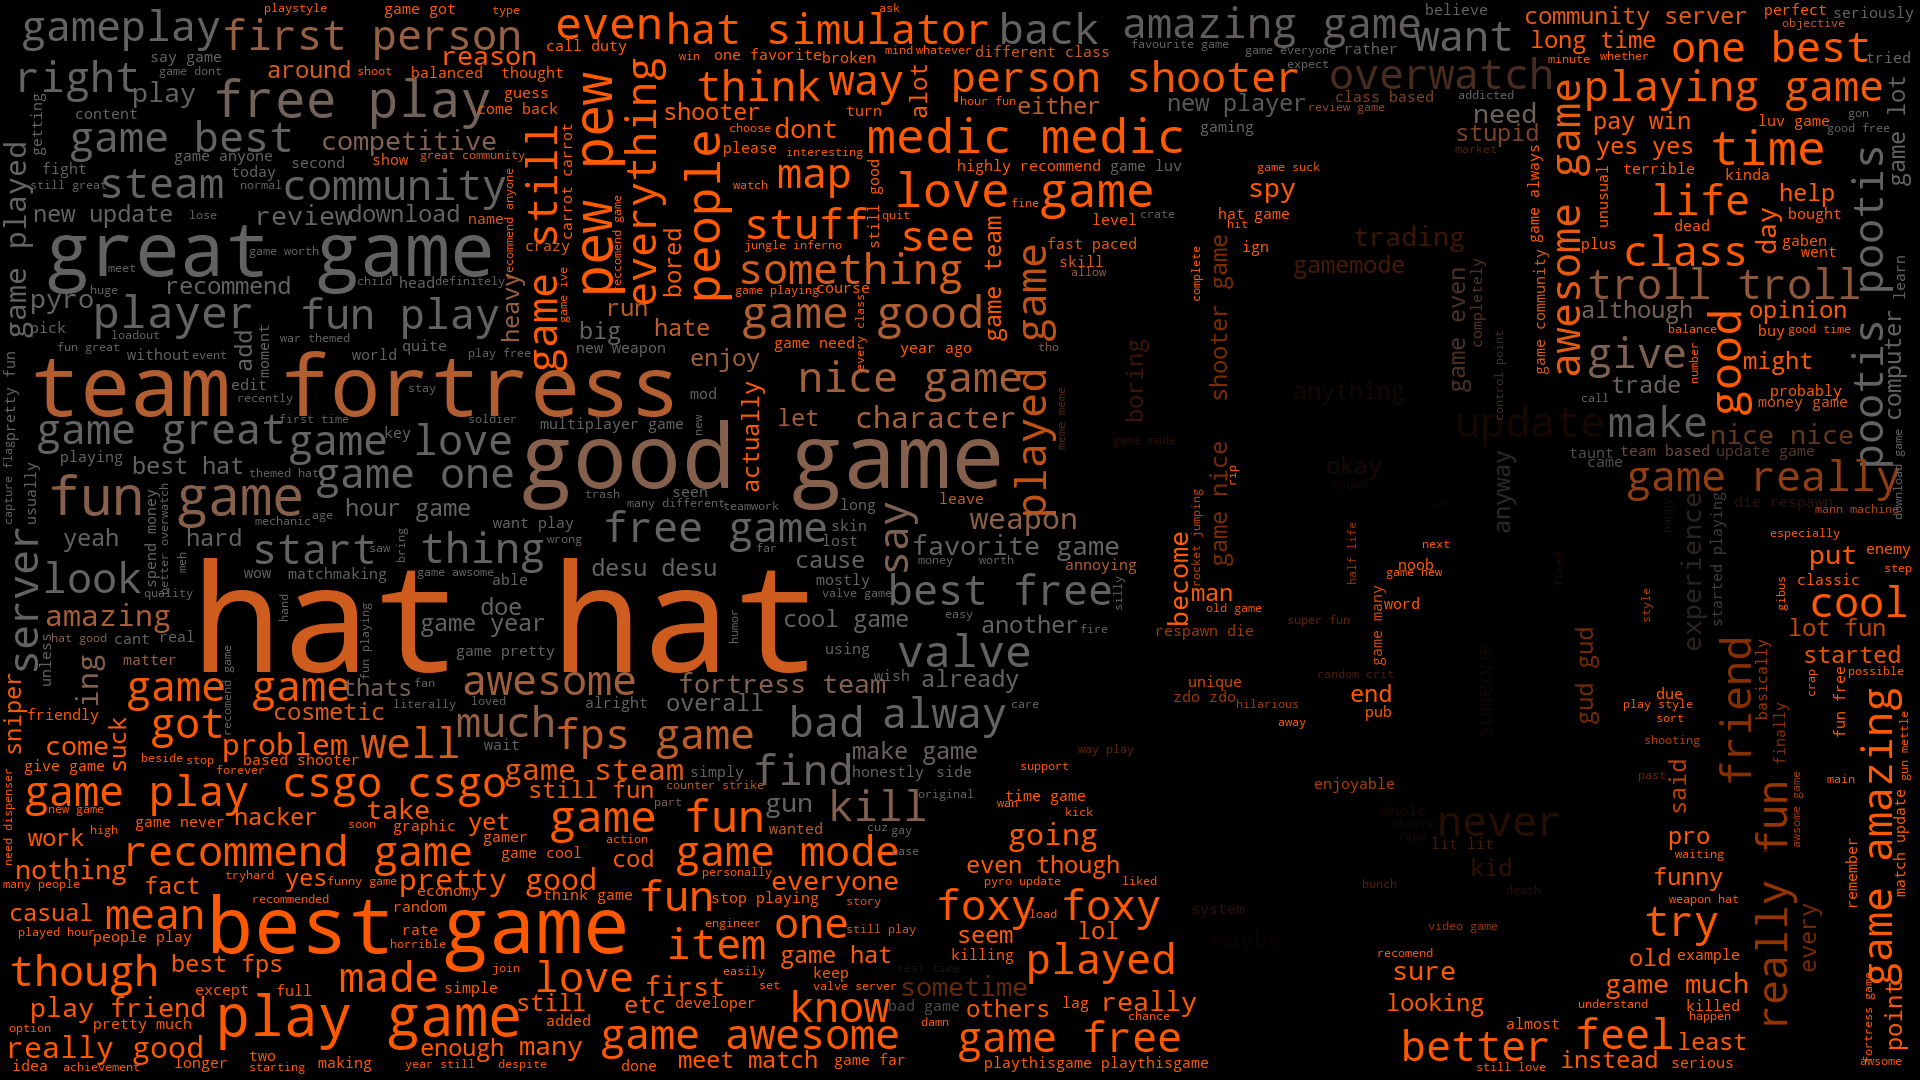

In [372]:
image_color=ImageColorGenerator(steam_img)
wc.recolor(color_func=image_color)
wc.to_image()

## Sistema de recomendacion

### Generando calificaciones

In [35]:
games_played_per_user = new_data_reviews.groupby("username").product_id.nunique()
games_played_per_user

username
! ! ŦŕĩŽǿЯëќ™ ! !           1
! A DIGGER'S GOTTA DIG !    1
! AgRee                     1
! Dr Feelgood               1
! EREN                      1
                           ..
󰀑Flaming Axe󰀑               1
󰀒Nullz󰀒                     1
󰀒Vosim󰀒                     1
󰀒abdarrahman802             1
󰀗S-Rabbit󰀗                  1
Name: product_id, Length: 493231, dtype: int64

In [34]:
average_games_played = games_played_per_user.mean()
average_games_played

1.3970237564176393

In [36]:
games_played_per_user.describe()

count    493231.000000
mean          1.396857
std           1.592501
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max         139.000000
Name: product_id, dtype: float64

In [37]:
weighted_games_played = games_played * (average_games_played / games_played_per_user)

NameError: name 'games_played' is not defined

### Filtro colaborativo